In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

if 'KERAS_BACKEND' not in os.environ:
    os.environ['KERAS_BACKEND'] = 'tensorflow'

In [63]:
import numpy as np
import bayesflow as bf

# Principle Bayesian Workflow for Cognitive Modeling with SSMS and BayesFlow

 In this tutorial, we go through the steps of a [principled Bayesian workflow](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html) for developing and applying cognitive models. To demonstrate this workflow, we simulate some cognitive processes using the [Sequential Sampling Model Simulators (SSMS)](https://lnccbrown.github.io/ssm-simulators/api/ssms/), the simulator backbone for the [Hierarchical Sequential Sampling Model (HSSM) toolbox](https://lnccbrown.github.io/HSSM/). From the simulated data, we perform Amortized Bayesian inference using [BayesFlow](https://bayesflow.org).

## Simulator

We start with the basic simulator from the HSSM toolbox.

In [64]:
from ssms.basic_simulators.simulator import simulator as ssm_sim

In [65]:
def ddm_simulator(
        v=None, a=None, z=None, t=None,
        n_samples: int=100
):
    
    ddm_sim = ssm_sim(model="ddm", theta=dict(v=v, a=a, z=z, t=t), n_samples=n_samples)

    rts = ddm_sim['rts'].astype(np.float32)
    choices = ddm_sim['choices'].astype(np.float32)

    return dict(rts=rts, choices=choices)

## Priors

Next, we will sample some priors from some distribution, as follows:

\begin{equation}
v \sim \mathrm{Gamma}(2, 0.8), \; a \sim \mathrm{Gamma}(10, 0.2), \; z \sim \mathrm{Beta}(2, 2), \; t \sim \mathrm{Gamma}(1.5, 0.2).
\end{equation}

In [66]:
def priors(rng=None):

    if rng is None:
        rng = np.random.default_rng()

    drift = rng.gamma(2, 0.8)
    threshold = rng.gamma(10, 0.2)
    bias = rng.beta(2, 2)
    ndt = rng.gamma(1.5, 0.2)

    return {'v': drift, 'a': threshold, 'z': bias, 't': ndt}

In [67]:
theta = priors()
theta

{'v': 0.8641115315601313,
 'a': 1.7764498824372812,
 'z': 0.7054805721411503,
 't': 0.25322624679027056}

## Putting everything together

After specifying the simulator and priors, we would wrap them together using BayesFlow's `make_simulator` function.

In [68]:
simulator = bf.make_simulator([priors, ddm_simulator])

In [69]:
draws = simulator.sample(batch_size=2)

In [70]:
print(draws['v'].shape)
print(draws['t'].shape)
print(draws['rts'].shape)
print(draws['choices'].shape)

(2, 1)
(2, 1)
(2, 100, 1)
(2, 100, 1)


## Prior Predictive Checks

To make sure that we are sampling the priors properly, BayesFlow has a pretty nice visual inspection in its `diagnostics` module that allows us to observe the samples directly.

In [71]:
prior_samples = simulator.simulators[0].sample(500)

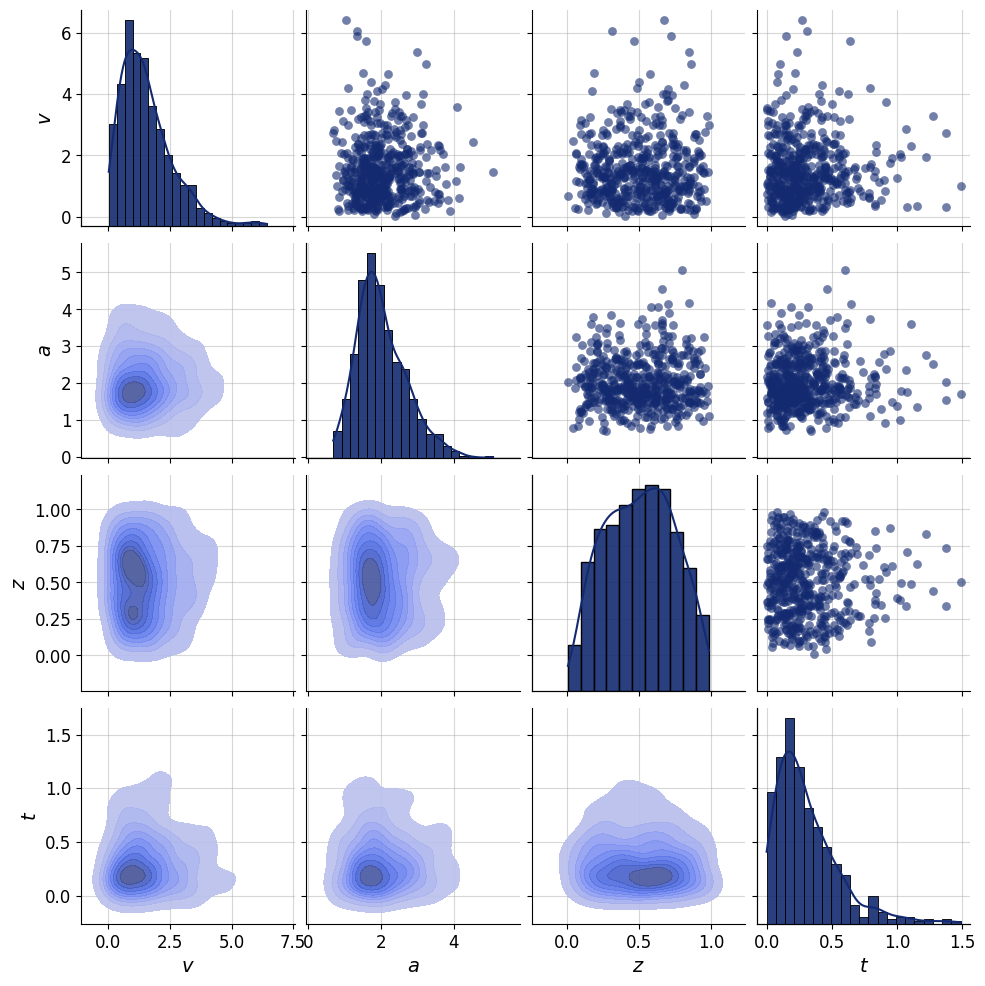

In [72]:
prior_grid = bf.diagnostics.plots.pairs_samples(
    samples=prior_samples, variable_names=[r'$v$', r'$a$', r'$z$', r'$t$']
)

## Adapter

To make sure that the simulated data and priors all friendly to the neural approximator, we use BayesFlow's `Adapter` to transform the data into summary variables and inference variables.

In a nutshell, from the perspective of the neural approximator:

* **Summary variables** are simulated data, and
* **Inference variables** are the parameters.

In [73]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype('float64', 'float32')
    .standardize()
    .concatenate(['v', 'a', 'z', 't'], into="inference_variables")
    .concatenate(['rts', 'choices'], into="summary_variables")
)

In [74]:
adapter

Adapter([0: ConvertDType -> 1: Standardize -> 2: Concatenate(['v', 'a', 'z', 't'] -> 'inference_variables') -> 3: Concatenate(['rts', 'choices'] -> 'summary_variables')])

We can inspect the transformed data after wrapping the simulation in the adapter to process.

In [75]:
adapted_sims = adapter(simulator.sample(10))

In [76]:
print(adapted_sims['summary_variables'].shape)
print(adapted_sims['inference_variables'].shape)

(10, 100, 2)
(10, 4)


## Neural approximator

The neural approximator is essentially a two-stage generative neural network consisting of a **summary network** and an **inference network**.

* **Summary network** takes the simulated data (*summary variables*) directly as inputs, and compress it into some latent summary statistics,
* **Inference network** takes the summary statistics as inputs, and infers the parameters (*inference variables*) from them.

In [77]:
summary_net = bf.networks.SetTransformer(summary_dim=32)

In [78]:
inference_net = bf.networks.FlowMatching()

## Workflow

BayesFlow makes everything easier by wrapping the amortization into a `Workflow` object. Here, we can simply use a `BasicWorkflow` object that bring together the simulator, the adapter, the summary network, and the inference network.

In [79]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_net,
    inference_network=inference_net
)

In [80]:
%%time 
_ = workflow.simulate(32)

CPU times: user 181 ms, sys: 3.33 ms, total: 184 ms
Wall time: 183 ms


## Training

Using the `BasicWorkflow` object, we can generate training data and validation data for training the neural approximator.

In [81]:
training_data = workflow.simulate(5000)
validation_data = workflow.simulate(300)

In [82]:
history = workflow.fit_offline(
    data=training_data,
    epochs=50,
    batch_size=32,
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 132ms/step - loss: 4.0875 - loss/inference_loss: 4.0875 - val_loss: 1.3248 - val_loss/inference_loss: 1.3248
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - loss: 1.5052 - loss/inference_loss: 1.5052 - val_loss: 1.0489 - val_loss/inference_loss: 1.0489
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - loss: 1.2106 - loss/inference_loss: 1.2106 - val_loss: 0.7171 - val_loss/inference_loss: 0.7171
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - loss: 1.0913 - loss/inference_loss: 1.0913 - val_loss: 0.8540 - val_loss/inference_loss: 0.8540
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - loss: 1.0152 - loss/inference_loss: 1.0152 - val_loss: 0.8190 - val_loss/inference_loss: 0.8190
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - loss: 0.9443 - loss/inference_loss: 0.9443 - val_loss: 1.0401 - val_loss/inference_loss: 1.0401
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - loss: 0.8672 - loss/infer

## Diagnostics

The `Workflow` object also gather all the diagnostics functionality that BayesFlow has to offer.

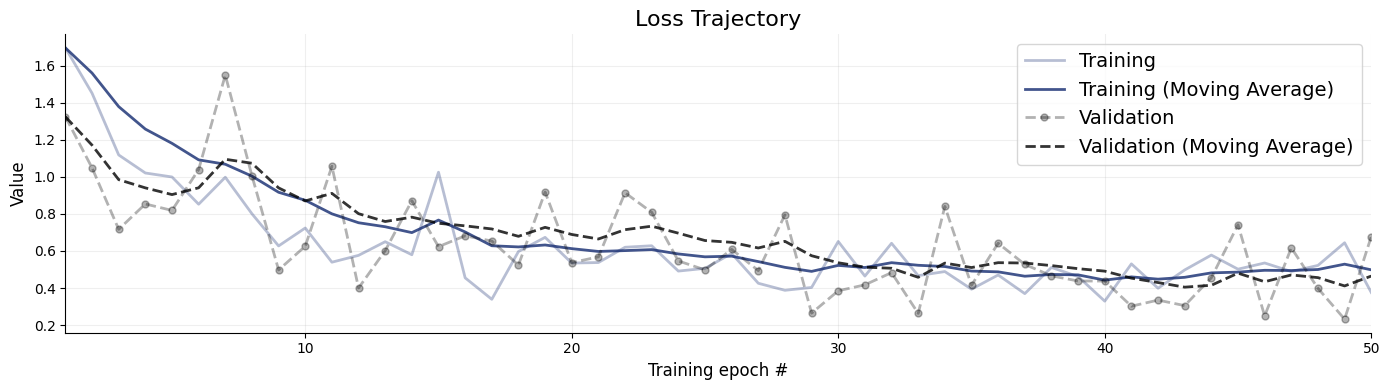

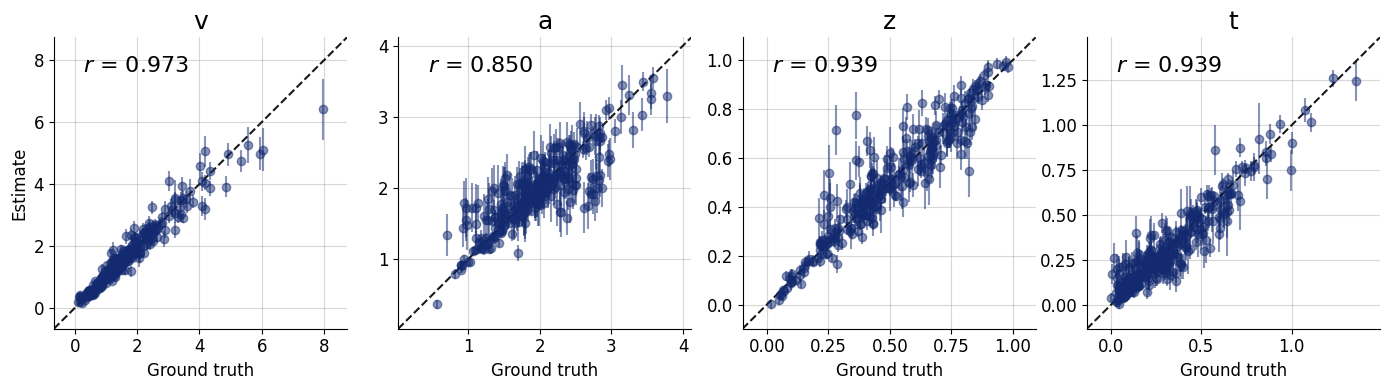

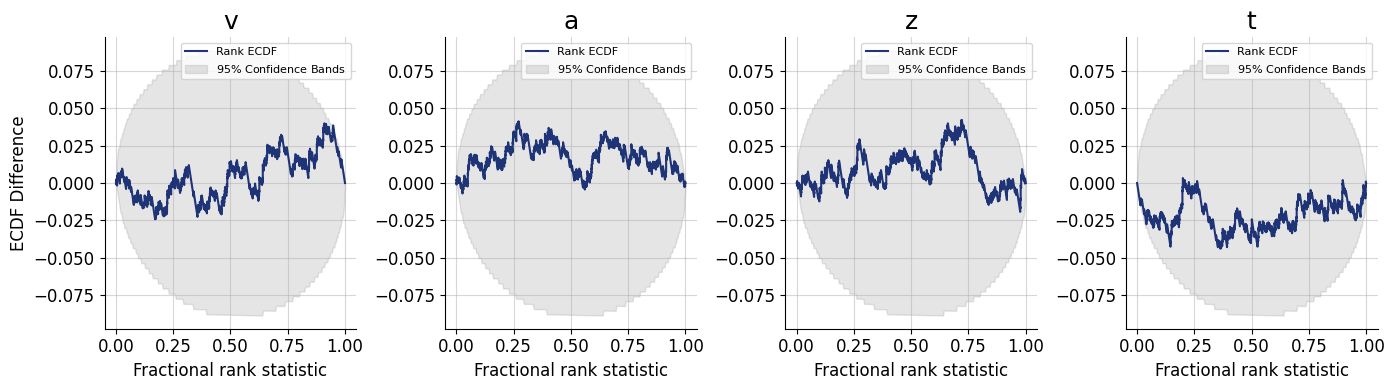

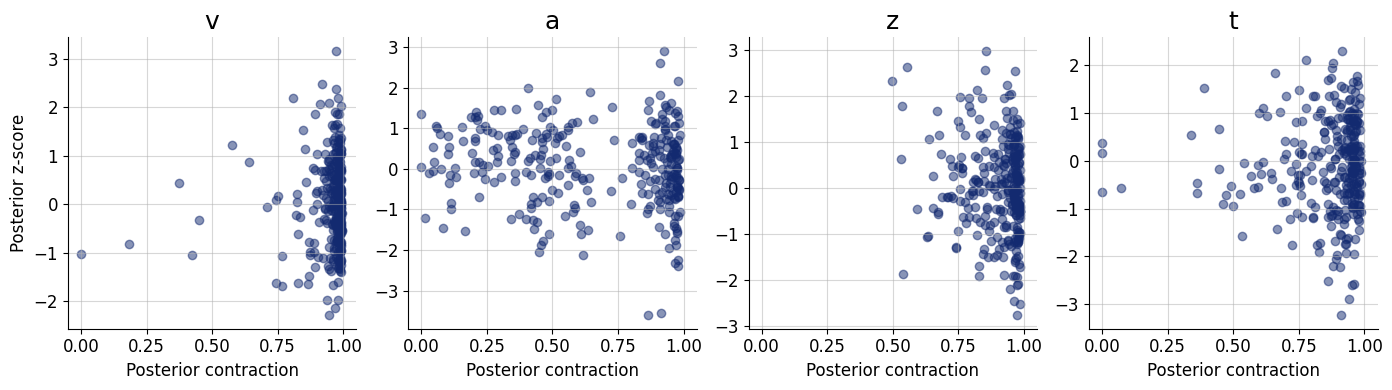

In [83]:
figures = workflow.plot_default_diagnostics(
    test_data=300,
    loss_kwargs={"figsize": (14, 4), "label_fontsize": 12},
    recovery_kwargs={"figsize": (14, 4), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (14, 4), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (14, 4), "label_fontsize": 12}    
)

More materials coming soon...